### Importing libraries

In [1]:
from dask_yarn import YarnCluster
from dask.distributed import Client

/home/hadoop/miniconda/lib/python3.8/site-packages/dask_yarn/core.py:16: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import (
/home/hadoop/miniconda/lib/python3.8/site-packages/dask_yarn/core.py:16: FutureWarning: parse_timedelta is deprecated and will be removed in a future release. Please use dask.utils.parse_timedelta instead.
  from distributed.utils import (


### Setting up client on dask cluster

In [2]:
# Create a cluster where each worker has 1 vCPU core and 2 GiB of memory:
# workers ~ processes, worker_vcores ~ threads
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 1,
                      worker_memory = "2GiB"
                      )

# Scale cluster out to 8 such workers:
cluster.scale(8)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://172.31.25.112:8786
distributed.scheduler - INFO -   dashboard at:                    :39543
22/06/03 15:58:51 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/03 15:58:52 INFO client.RMProxy: Connecting to ResourceManager at ip-172-31-25-112.ec2.internal/172.31.25.112:8032
22/06/03 15:58:53 INFO client.AHSProxy: Connecting to Application History server at ip-172-31-25-112.ec2.internal/172.31.25.112:10200
22/06/03 15:58:53 INFO skein.Driver: Driver started, listening on 41467
22/06/03 15:58:53 INFO conf.Configuration: resource-types.xml not found
22/06/03 15:58:53 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
22/06/03 15:58:54 INFO skein.Driver: Uploading application resources to hdfs://ip-172-31-25-112.ec2.internal:8020/user/hadoop/.skein/application_1654271317377_0001
22/06/03 15

In [3]:
import dask.dataframe as dd

/home/hadoop/miniconda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/hadoop/miniconda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/hadoop/miniconda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


### Reading in classified sentiments of posts from s3 bucket

In [12]:
df = dd.read_csv('s3://pranathi-sentiment/final_classification.csv')

In [8]:
def transform(x):
    if x =='neutral':
        return 0
    elif x=='positive':
        return 1
    else:
        return -1

### Transforming categorical data (sentiment)

In [13]:
df['class']= df['class'].apply(transform, meta=('class', 'int64'))

In [15]:
final_df = df.groupby('date').mean()
                                                       

### Reading in data with historical S&P index performance

In [19]:
df_1 = dd.read_csv('s3://pranathi-sentiment/Historical_S&p.csv')
df_1['change'] = (df_1['Close/Last'] - df_1['Open'])/df_1['Open']

### Converting date format from epoch to YYYY-MM-DD so that both sources of data can be merged

In [21]:
import time

#df['conv_date'] = df['Date'].apply(lambda x: time.strftime("%Y-%m-%d ", time.gmtime(x)))
df_1['Date'] = dd.to_datetime(df_1['Date']).dt.strftime('%Y-%m-%d ')

In [24]:
df_11 = df_1.rename(columns = {'Date':'date'})

In [26]:
final_corr_df = dd.merge(final_df, df_11, how = 'inner', on = 'date')

### Computing correlation

In [34]:
final_corr_df.corr(method = 'pearson', split_every = False).compute()

,class,Close/Last,Open,High,Low,change
class,1.000000,0.145916,0.134878,0.130522,0.157379,0.047939
Close/Last,0.145916,1.000000,0.974340,0.985957,0.988799,0.121523
Open,0.134878,0.974340,1.000000,0.991986,0.987067,-0.104782
High,0.130522,0.985957,0.991986,1.000000,0.984710,-0.017446
Low,0.157379,0.988799,0.987067,0.984710,1.000000,0.015769
change,0.047939,0.121523,-0.104782,-0.017446,0.015769,1.000000


In [39]:
final_corr_df = final_corr_df.compute()

### Plotting change in S&P index against average sentiment of posts per day

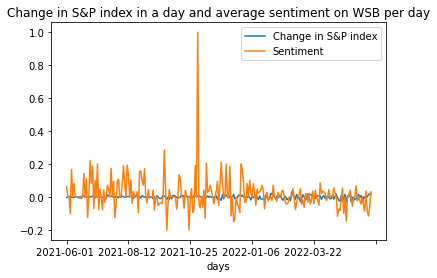

In [43]:
import matplotlib.pyplot as plt
final_corr_df.plot(x = 'date', y = ['change', 'class'], kind = 'line')
plt.title('Change in S&P index in a day and average sentiment on WSB per day')
plt.legend(['Change in S&P index', 'Sentiment'])
plt.xlabel('days')
plt.show()